# 07 — Explainability: SHAP (XGB) + Linear Coeffs

In [1]:
%pip -q install shap xgboost scikit-learn pandas numpy matplotlib

Loaded: dataset_features_labels_with_sentiment.csv
XGB R2: -0.38382854803804656


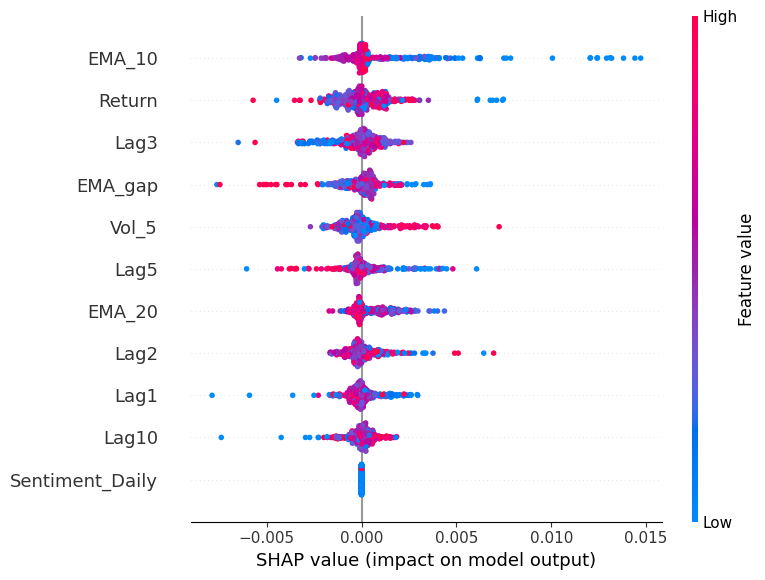

Saved shap_summary_xgb.png
Linear R2: -0.05069549544935792


,feature,coef
5,Lag10,0.090735
2,Lag2,0.041684
1,Lag1,0.040948
3,Lag3,0.011283
7,EMA_10,0.000185
8,EMA_20,-0.000190
6,Vol_5,-0.004592
10,Sentiment_Daily,-0.008482
0,Return,-0.031377
4,Lag5,-0.074089


In [2]:

import shap, numpy as np, pandas as pd, matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# โหลดชุดฟีเจอร์ (ถ้ามี sentiment จะใช้ไฟล์นั้นก่อน)
for f in ["dataset_features_labels_with_sentiment.csv","dataset_features_labels.csv"]:
    try:
        df = pd.read_csv(f, index_col=0, parse_dates=True); print("Loaded:", f); break
    except: pass
assert 'df' in globals(), "ไม่พบ dataset_features_labels*.csv — รัน 02/06 ก่อน"

FEATURES = [c for c in df.columns if c!="Target"]
X, y = df[FEATURES].values, df["Target"].values
n=len(df); n_train=int(n*0.7); n_val=int(n*0.85)
X_train, y_train = X[:n_val], y[:n_val]
X_test,  y_test  = X[n_val:], y[n_val:]

# --- XGB ---
xgb = XGBRegressor(
    n_estimators=400, max_depth=4, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, random_state=42
)
xgb.fit(X_train, y_train)
print("XGB R2:", r2_score(y_test, xgb.predict(X_test)))

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(9,5))
shap.summary_plot(shap_values, features=X_test, feature_names=FEATURES, show=False)
plt.tight_layout(); plt.savefig("shap_summary_xgb.png", dpi=150); plt.show()
print("Saved shap_summary_xgb.png")

# --- Linear ---
lin = LinearRegression().fit(X_train, y_train)
print("Linear R2:", r2_score(y_test, lin.predict(X_test)))
coef_df = pd.DataFrame({"feature": FEATURES, "coef": lin.coef_}).sort_values("coef", ascending=False)
coef_df.to_csv("linear_coefficients.csv", index=False)
coef_df.head(10)
